In [1]:
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt



In [8]:
#visualization functions
def show(tensor, ch=1, size=(28,28), num=16):
  #tensor: 128 as batchsize, * 784
  data = tensor.detach().cpu().view(-1, ch, *size) #>> 128 * 1 * 28 *28
  grid = make_grid(data[:num], nrow=4).permute(1,2,0) # 1 * 28 * 28 >> matlplotlib
  plt.imshow(grid)
  plt.show()

In [3]:
# setup of the main parameters and hyperparameters
epochs = 500
cur_step = 0
info_step = 300
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss() #sigmoid 0-1, binary cross entorpy

bs = 128
device = 'cuda'

dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()), shuffle=True, batch_size=bs)

# number of steps = 60000 /128 = 458.75 steps over the enter data

100%|██████████| 9912422/9912422 [00:00<00:00, 110301759.34it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 92824286.46it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31670664.78it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20888737.68it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
# declare our model
#Generator

def genBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.BatchNorm1d(out),
      nn.ReLU(inplace=True)

  )

class Generator(nn.Module):
  def __init__(self, z_dim=64, i_dim=784, h_dim=128):
    super().__init__()
    self.gen =nn.Sequential(
        genBlock(z_dim, h_dim),
        genBlock(h_dim, h_dim*2),
        genBlock(h_dim*2, h_dim*4),
        genBlock(h_dim*4, h_dim*8),
        nn.Linear(h_dim*8, i_dim), # 1024 >> 784
        nn.Sigmoid()
    )

  def forward(self, noise):
    return self.gen(noise)


def gen_noise(number, z_dim):
  return torch.randn(number, z_dim).to(device)



#Discriminator
def discBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.LeakyReLU(0.2)
  )


class Discriminator(nn.Module):
  def __init__(self, i_dim=784, h_dim=256):
    super().__init__()
    self.disc = nn.Sequential(
        discBlock(i_dim, h_dim*4),# 784 >> 102
        discBlock(h_dim*4, h_dim*2),
        discBlock(h_dim*2, h_dim),
        nn.Linear(h_dim, 1)
    )
  def forward(self, image):
    return self.disc(image)

In [5]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [6]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [7]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [9]:
x, y = next(iter(dataloader))

print(x.shape, y.shape)
print(y[:10])

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([9, 7, 6, 3, 7, 0, 5, 9, 6, 8])


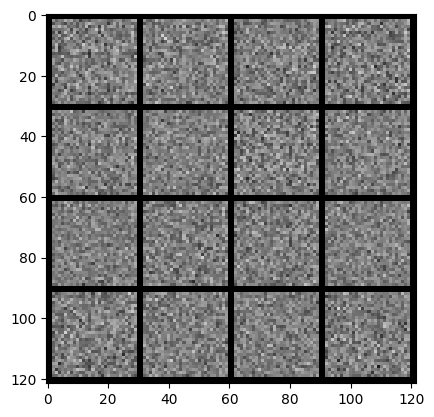

In [10]:
noise = gen_noise(bs, z_dim)
fake = gen(noise)
show(fake)

In [11]:
#Calculating the loss
# generator loss

def cal_gen_loss(loss_fun, gen, disc, number, z_dim):
  noise = gen_noise(number, z_dim)
  fake = gen(noise)
  pred = disc(fake)
  targets = torch.ones_like(pred)
  gen_loss = loss_func(pred, targets)
  return gen_loss


def cal_disc_loss(loss_func, gen, disc, number, real, z_dim):
  noise = gen_noise(number, z_dim)
  fake = gen(noise)
  disc_fake = disc(fake.detach())
  disc_fake_traget = torch.zeros_like(disc_fake)
  disc_fake_loss = loss_func(disc_fake, disc_fake_traget)

  disc_real = disc(real)
  disc_real_targets = torch.ones_like(disc_real)
  disc_real_loss = loss_func(disc_real, disc_real_targets)

  disc_loss = (disc_fake_loss+disc_real_loss)/2
  return disc_loss

  0%|          | 0/469 [00:00<?, ?it/s]

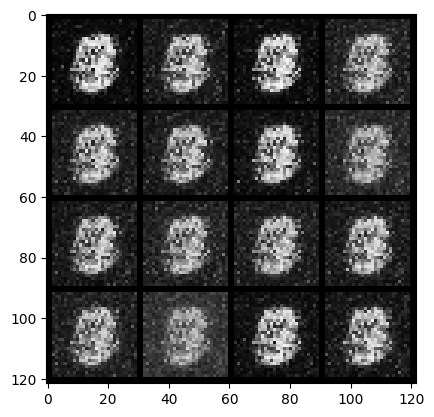

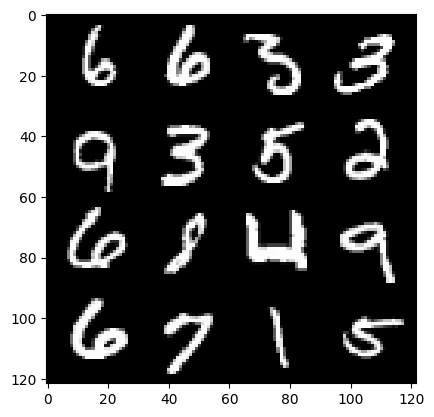

0: step 300 / Gen loss: 1.967475321888923 / disc_loss: 0.330717359383901


  0%|          | 0/469 [00:00<?, ?it/s]

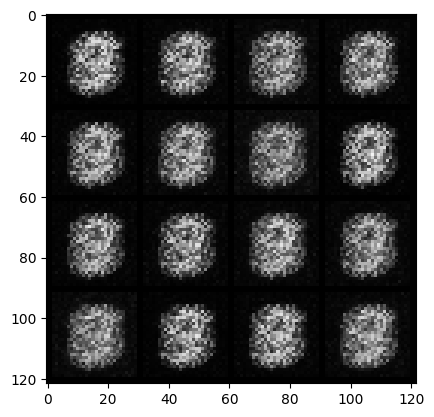

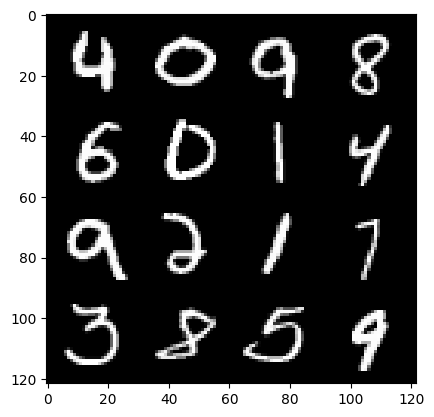

1: step 600 / Gen loss: 3.5240620422363276 / disc_loss: 0.11887651073435947


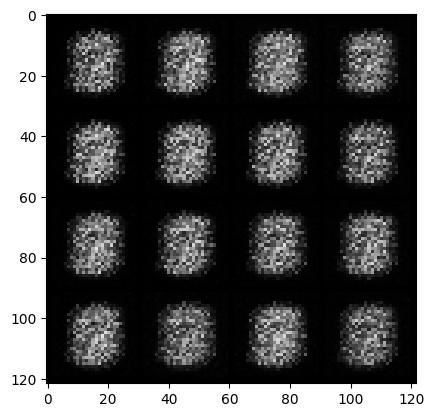

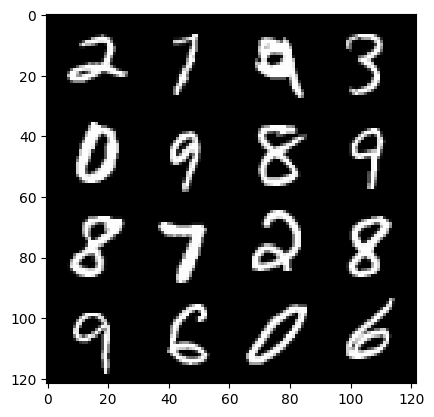

1: step 900 / Gen loss: 3.4196819599469483 / disc_loss: 0.05814356693377095


  0%|          | 0/469 [00:00<?, ?it/s]

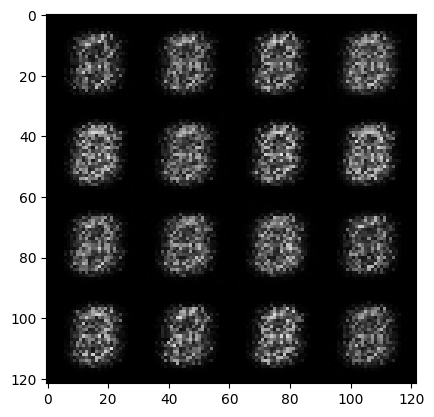

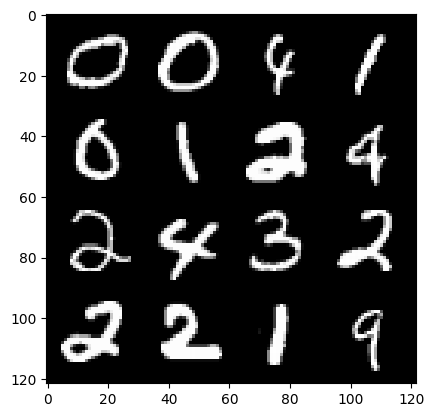

2: step 1200 / Gen loss: 3.5340789095560683 / disc_loss: 0.03794885613645115


  0%|          | 0/469 [00:00<?, ?it/s]

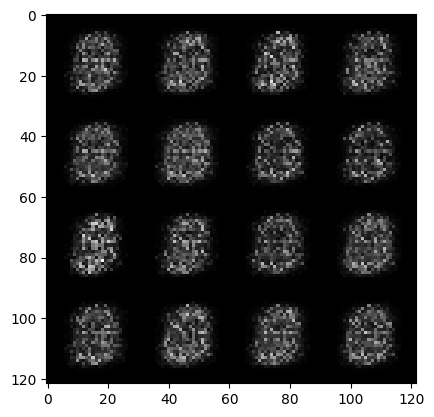

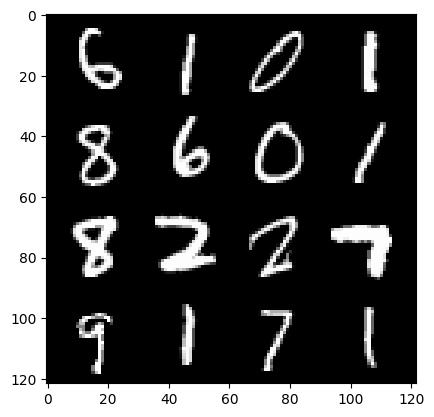

3: step 1500 / Gen loss: 3.4852969566980985 / disc_loss: 0.03852041592821478


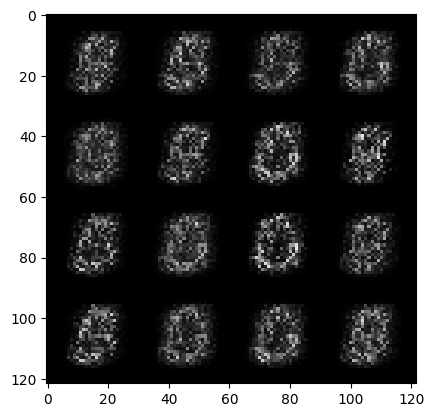

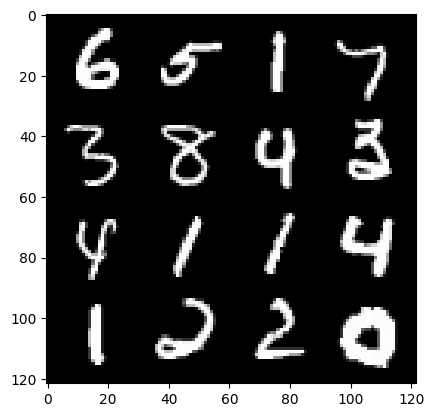

3: step 1800 / Gen loss: 3.4839358178774504 / disc_loss: 0.04639824301625294


  0%|          | 0/469 [00:00<?, ?it/s]

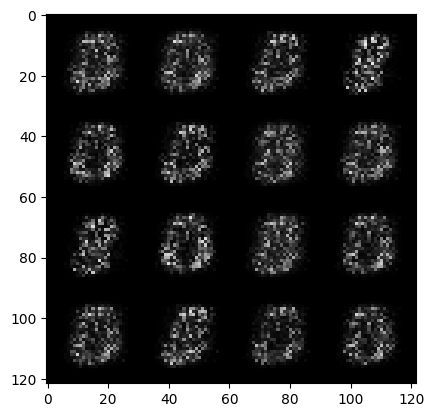

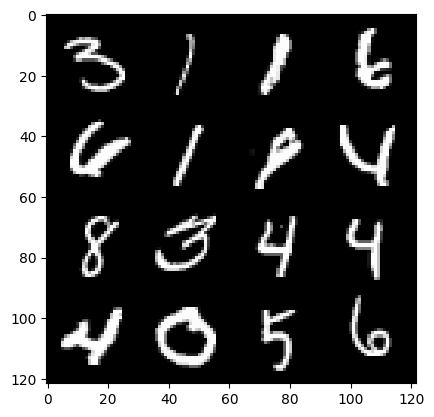

4: step 2100 / Gen loss: 3.691402126948039 / disc_loss: 0.04149378251905243


  0%|          | 0/469 [00:00<?, ?it/s]

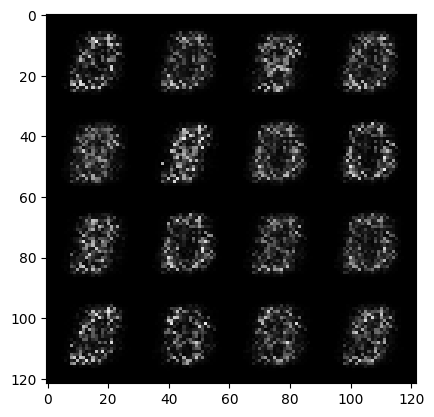

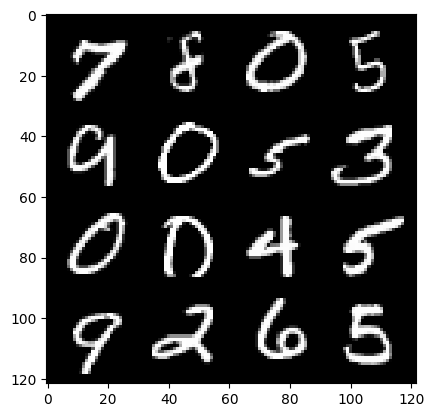

5: step 2400 / Gen loss: 4.038584563732146 / disc_loss: 0.0320536261362334


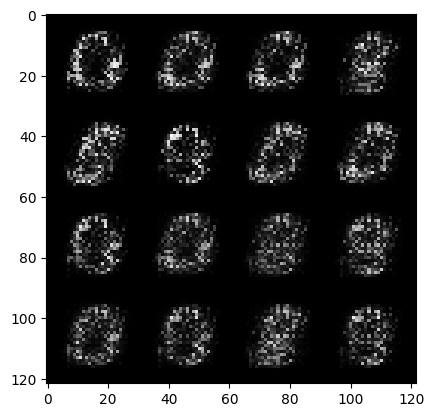

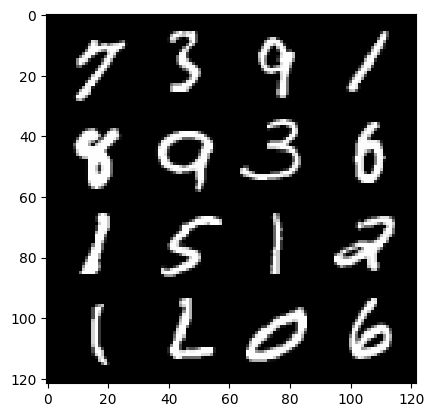

5: step 2700 / Gen loss: 4.439315911928814 / disc_loss: 0.02368488948481778


  0%|          | 0/469 [00:00<?, ?it/s]

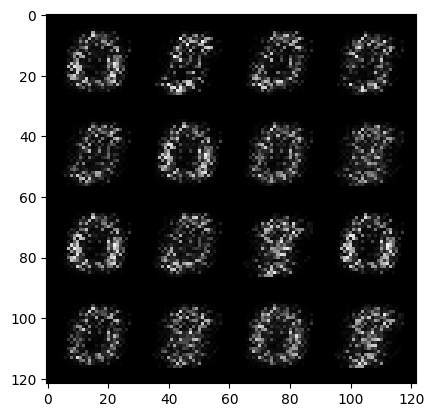

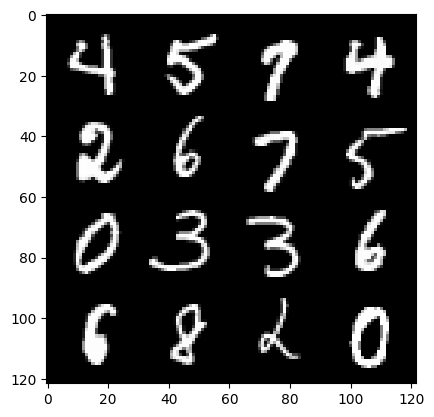

6: step 3000 / Gen loss: 4.7756797472635935 / disc_loss: 0.021418762188404793


  0%|          | 0/469 [00:00<?, ?it/s]

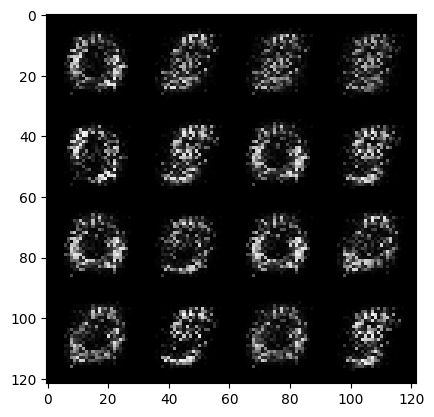

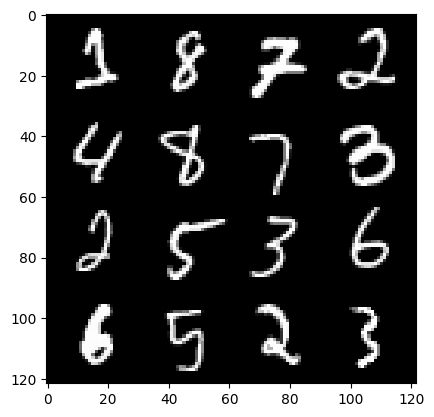

7: step 3300 / Gen loss: 5.149299235343933 / disc_loss: 0.016844575352345913


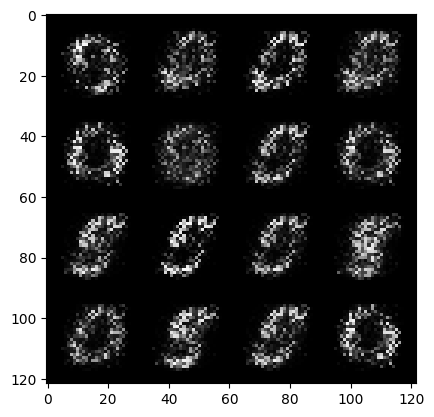

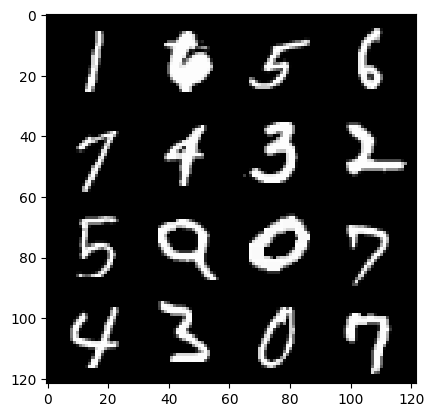

7: step 3600 / Gen loss: 5.361264750162761 / disc_loss: 0.017233361857943236


  0%|          | 0/469 [00:00<?, ?it/s]

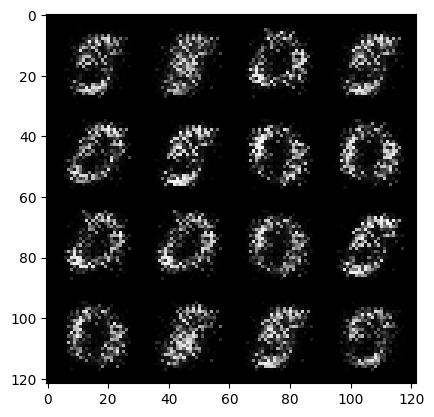

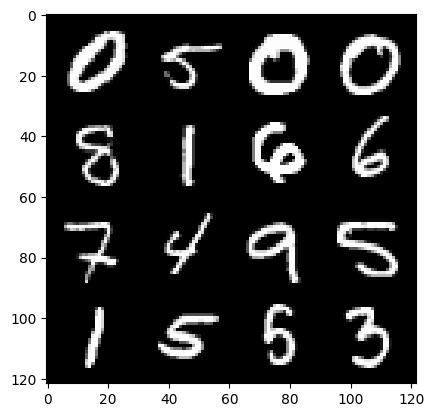

8: step 3900 / Gen loss: 5.832508743604023 / disc_loss: 0.01822819293942302


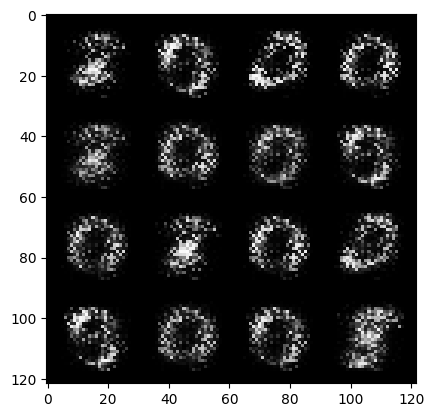

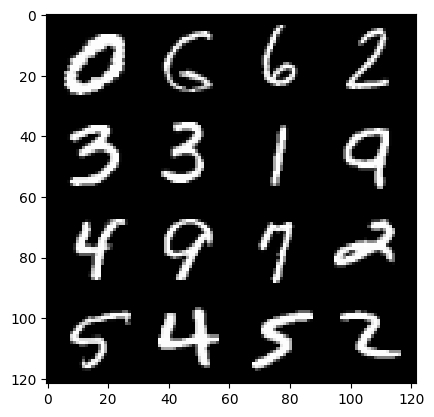

8: step 4200 / Gen loss: 5.8347440894444755 / disc_loss: 0.01573438901609431


  0%|          | 0/469 [00:00<?, ?it/s]

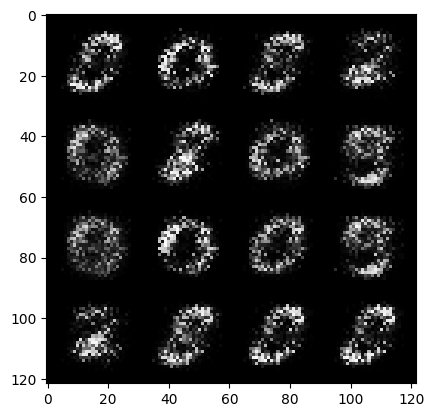

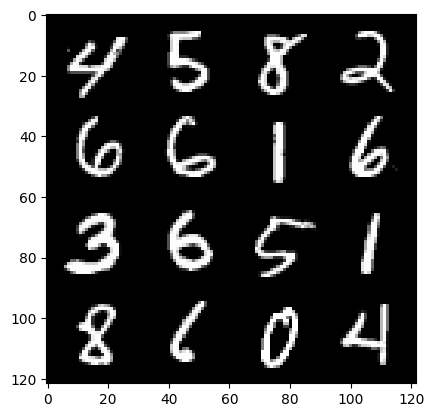

9: step 4500 / Gen loss: 6.019289452234904 / disc_loss: 0.017347456190424656


  0%|          | 0/469 [00:00<?, ?it/s]

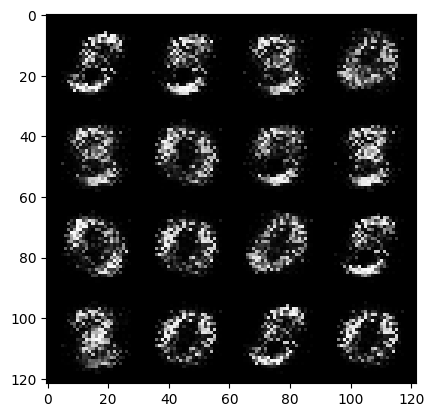

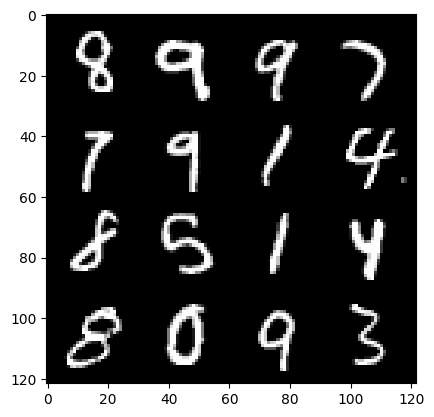

10: step 4800 / Gen loss: 6.207708864212029 / disc_loss: 0.015101850329277418


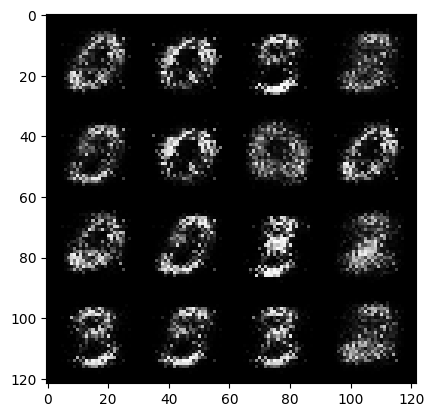

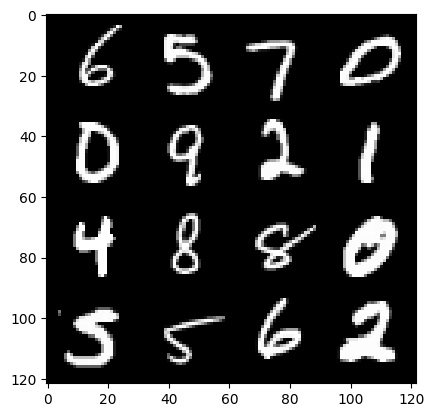

10: step 5100 / Gen loss: 6.495848372777306 / disc_loss: 0.013984845868932692


  0%|          | 0/469 [00:00<?, ?it/s]

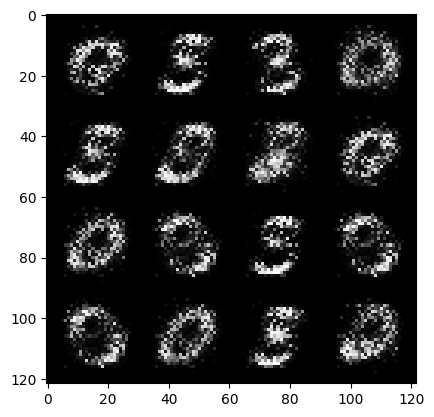

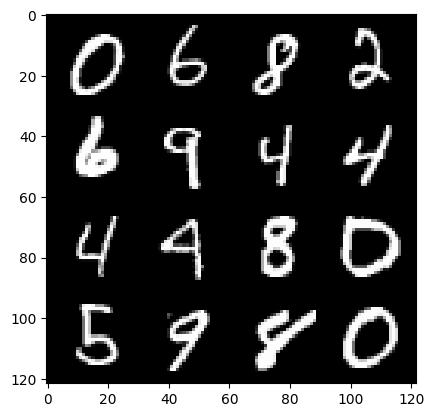

11: step 5400 / Gen loss: 5.992556980450945 / disc_loss: 0.013648697414125005


  0%|          | 0/469 [00:00<?, ?it/s]

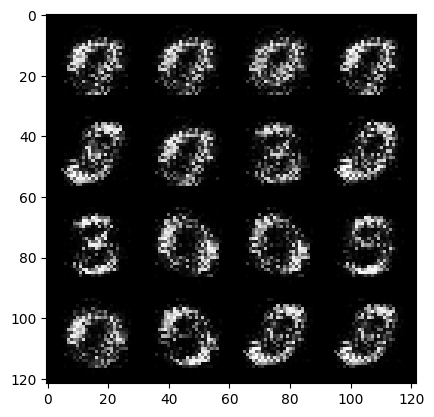

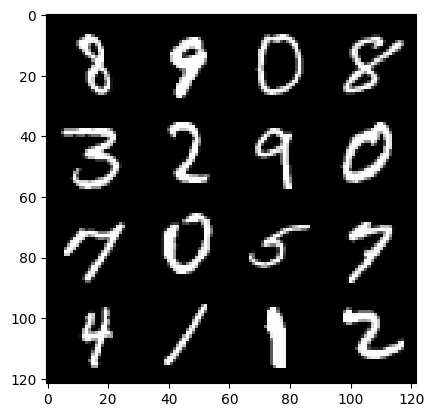

12: step 5700 / Gen loss: 6.099160331090293 / disc_loss: 0.012658795835450293


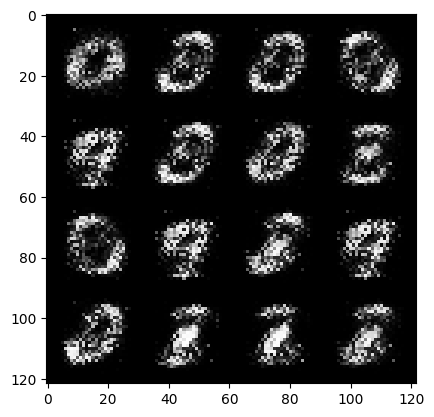

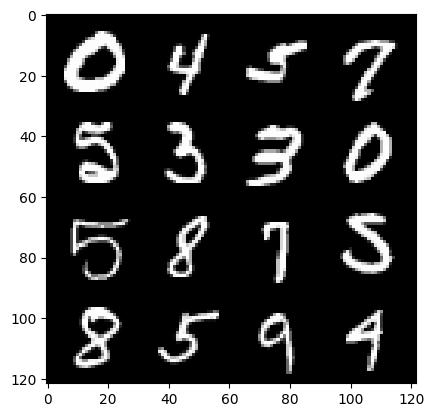

12: step 6000 / Gen loss: 6.05455861568451 / disc_loss: 0.01312003103084862


  0%|          | 0/469 [00:00<?, ?it/s]

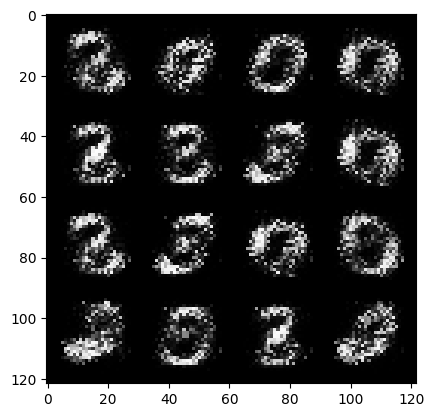

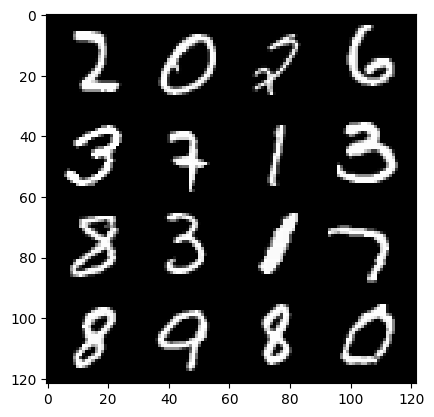

13: step 6300 / Gen loss: 6.665483779907229 / disc_loss: 0.00991235322784632


  0%|          | 0/469 [00:00<?, ?it/s]

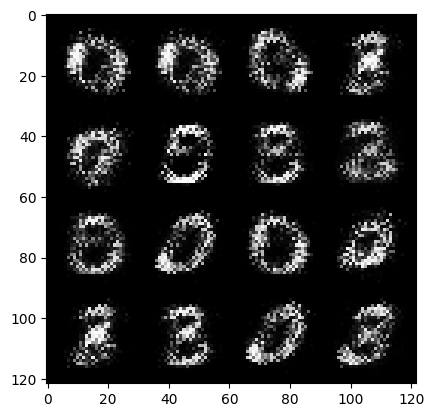

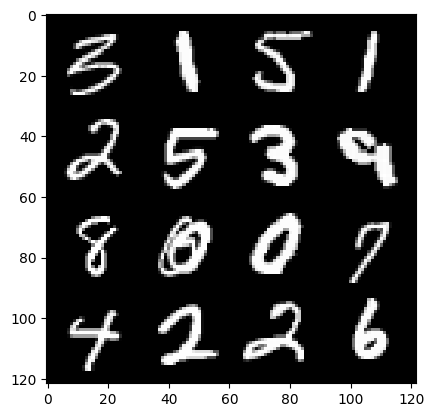

14: step 6600 / Gen loss: 6.470395944913231 / disc_loss: 0.008608168048473695


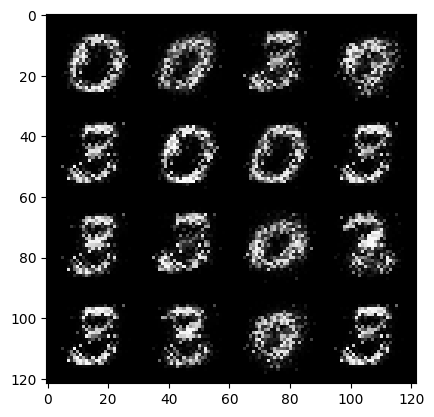

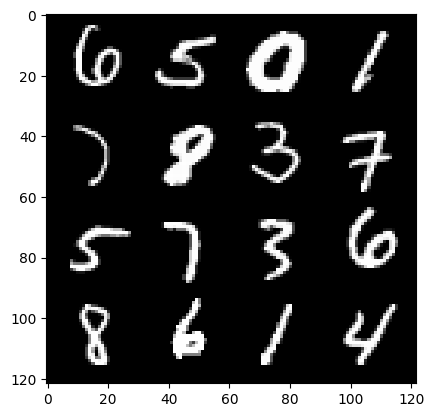

14: step 6900 / Gen loss: 6.540957651138303 / disc_loss: 0.007964984668263543


  0%|          | 0/469 [00:00<?, ?it/s]

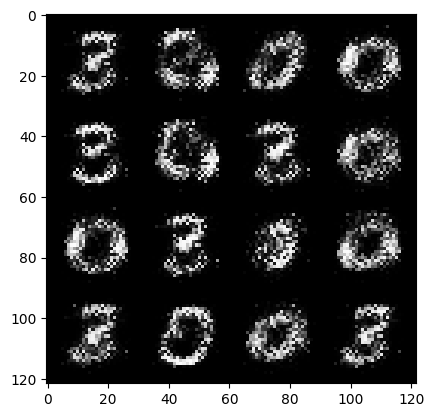

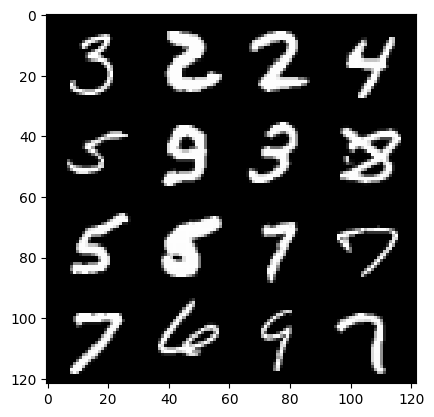

15: step 7200 / Gen loss: 6.686869661013288 / disc_loss: 0.007868960276246072


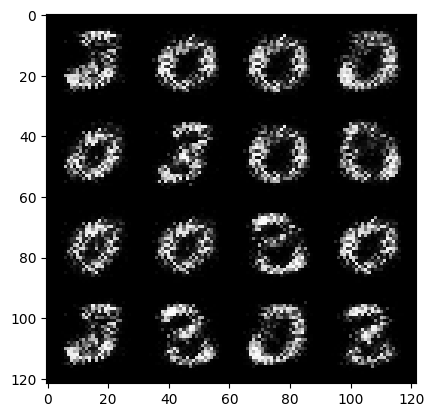

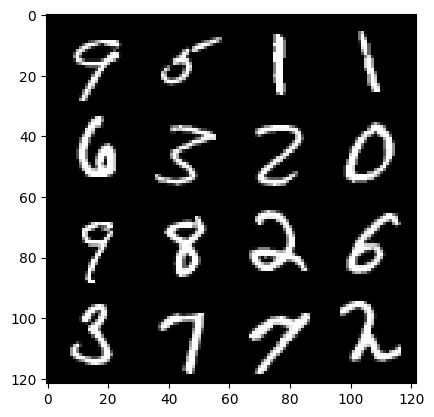

15: step 7500 / Gen loss: 6.430796610514321 / disc_loss: 0.00851497526047751


  0%|          | 0/469 [00:00<?, ?it/s]

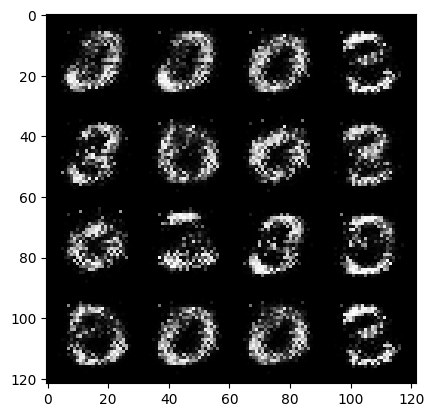

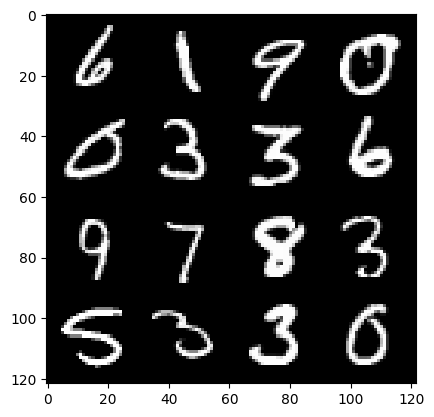

16: step 7800 / Gen loss: 6.669468746185305 / disc_loss: 0.009497038696814947


  0%|          | 0/469 [00:00<?, ?it/s]

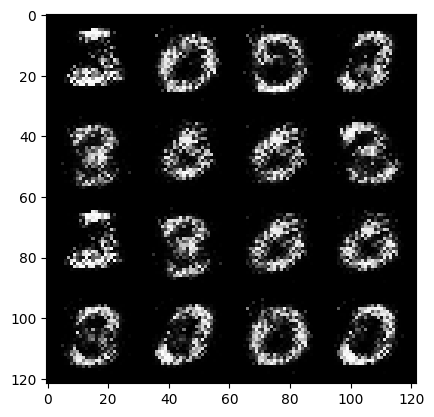

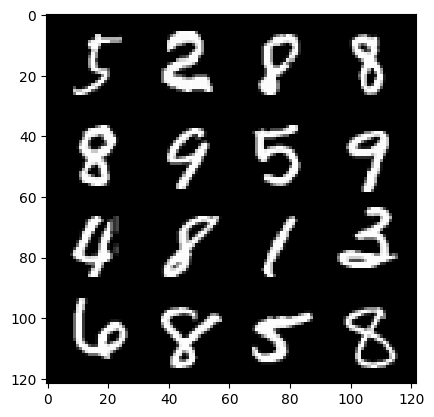

17: step 8100 / Gen loss: 6.505278420448307 / disc_loss: 0.009659336857342476


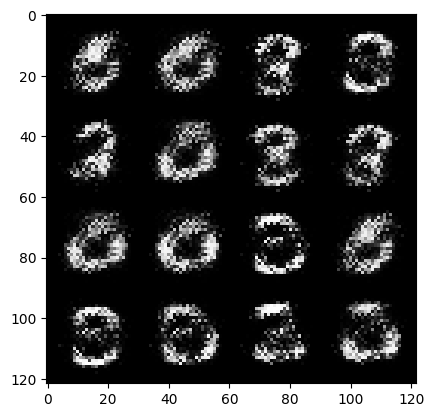

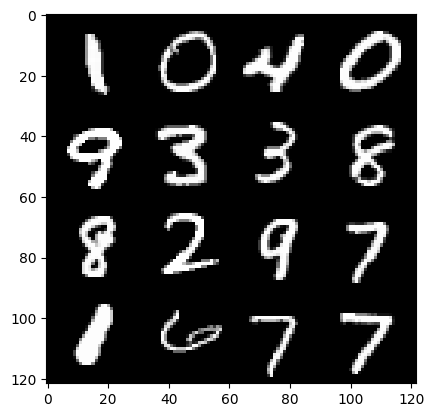

17: step 8400 / Gen loss: 6.4460940440495795 / disc_loss: 0.01158233621235316


  0%|          | 0/469 [00:00<?, ?it/s]

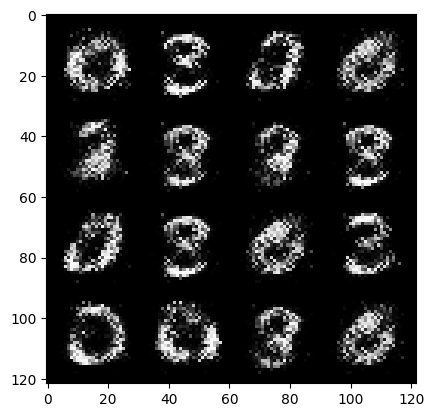

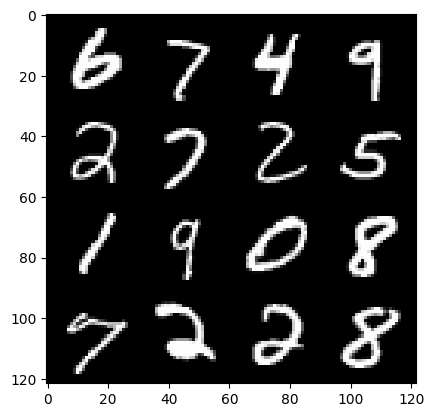

18: step 8700 / Gen loss: 6.352649350166321 / disc_loss: 0.010112095101115602


  0%|          | 0/469 [00:00<?, ?it/s]

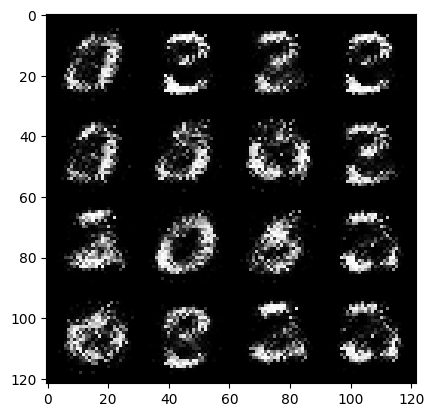

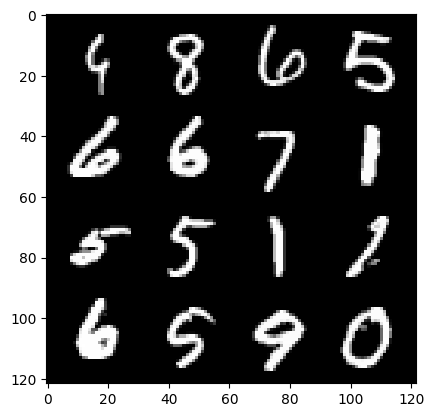

19: step 9000 / Gen loss: 6.649621740976969 / disc_loss: 0.008598472593973077


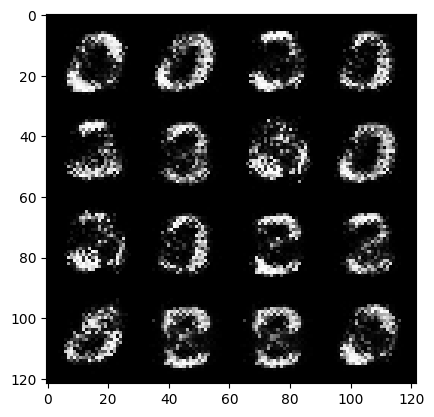

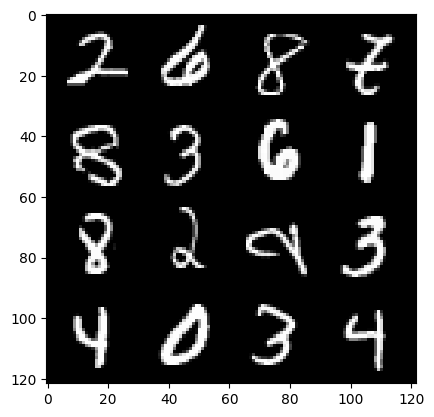

19: step 9300 / Gen loss: 7.282512585322061 / disc_loss: 0.009196547849569475


  0%|          | 0/469 [00:00<?, ?it/s]

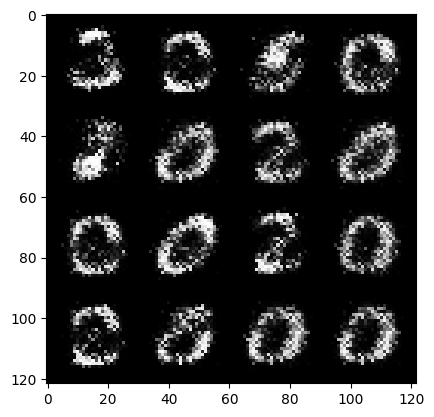

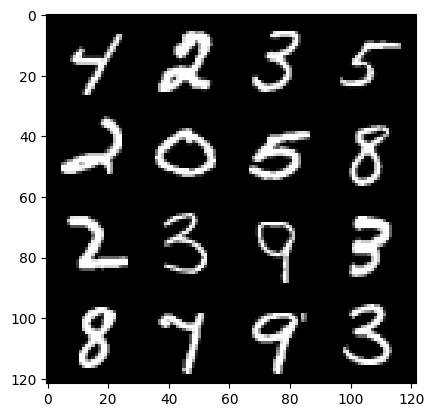

20: step 9600 / Gen loss: 7.268274302482606 / disc_loss: 0.009356694410089404


  0%|          | 0/469 [00:00<?, ?it/s]

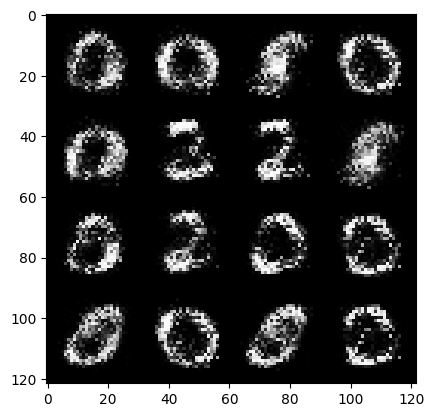

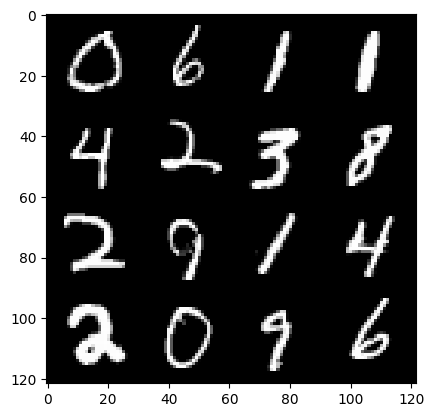

21: step 9900 / Gen loss: 7.431468575795493 / disc_loss: 0.010608156888823338


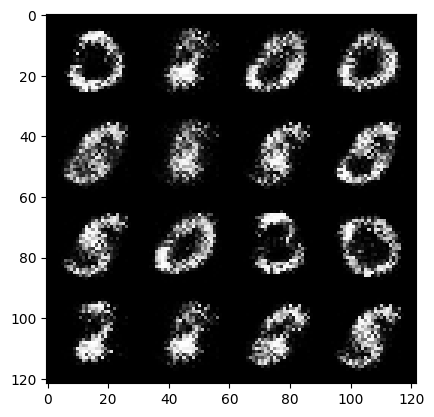

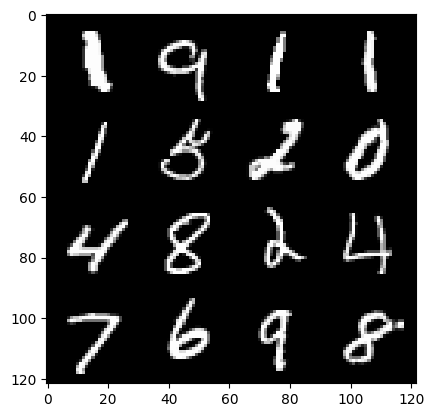

21: step 10200 / Gen loss: 6.818257234891258 / disc_loss: 0.013106770954715711


  0%|          | 0/469 [00:00<?, ?it/s]

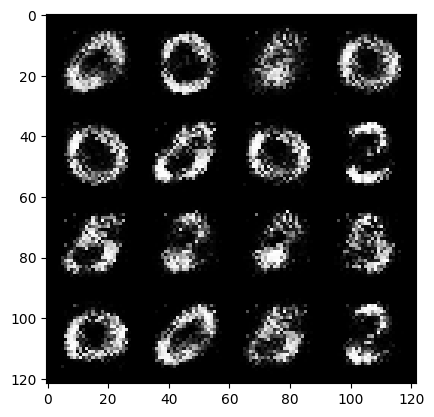

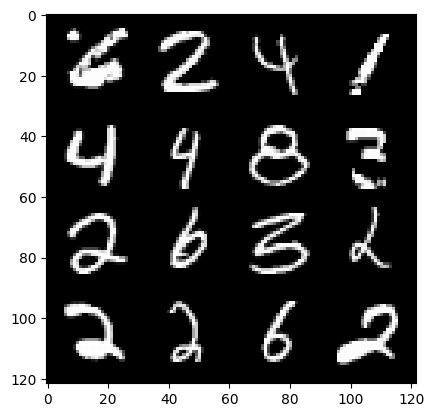

22: step 10500 / Gen loss: 6.454639463424685 / disc_loss: 0.011373705239578457


  0%|          | 0/469 [00:00<?, ?it/s]

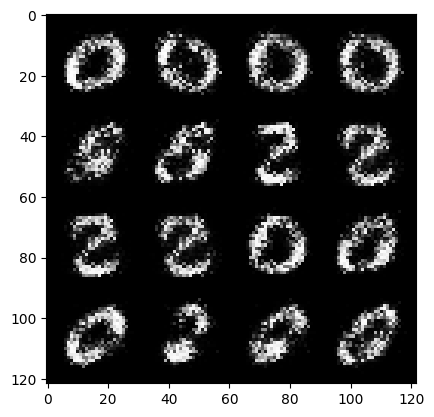

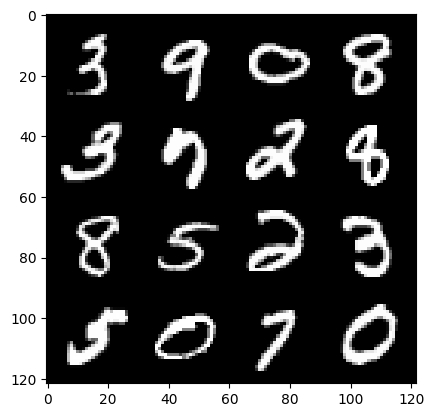

23: step 10800 / Gen loss: 6.713521057764694 / disc_loss: 0.010180863105536744


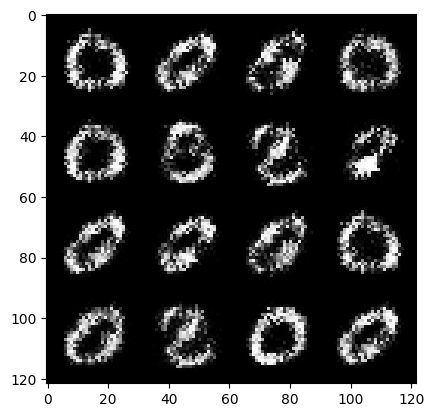

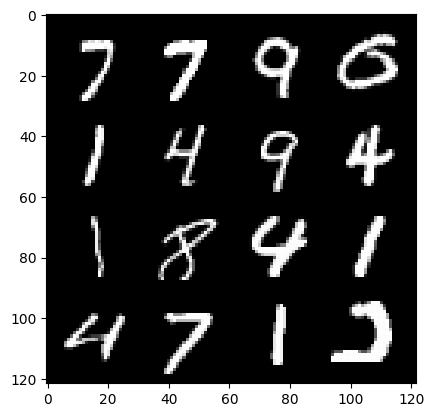

23: step 11100 / Gen loss: 7.061636330286663 / disc_loss: 0.010579904332601775


  0%|          | 0/469 [00:00<?, ?it/s]

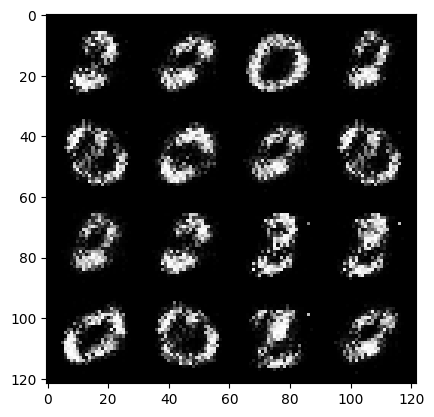

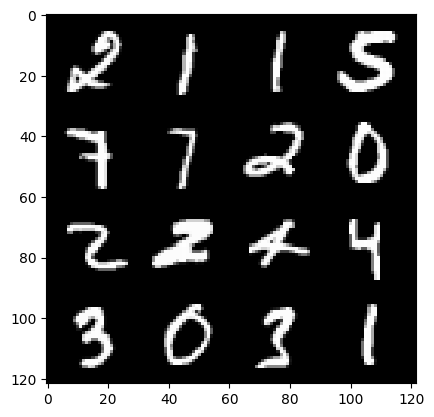

24: step 11400 / Gen loss: 7.15610002040863 / disc_loss: 0.011421401356346905


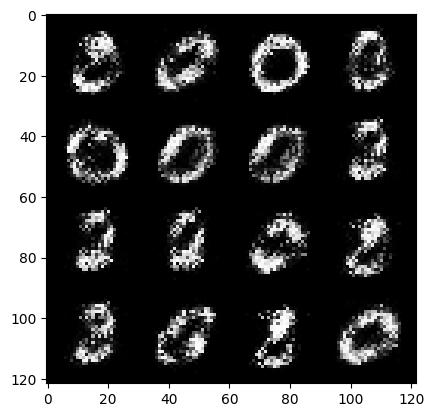

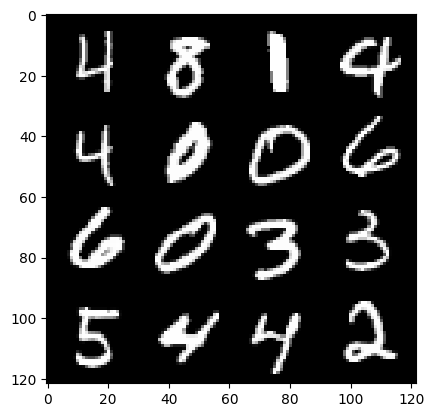

24: step 11700 / Gen loss: 6.801685973803203 / disc_loss: 0.0129778216208797


  0%|          | 0/469 [00:00<?, ?it/s]

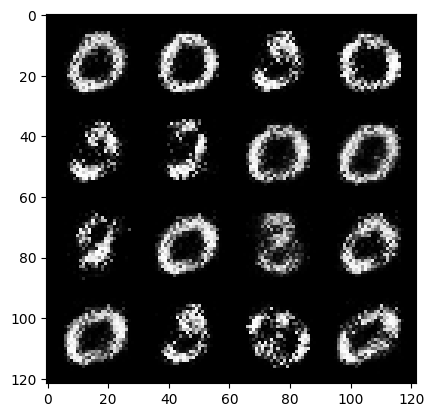

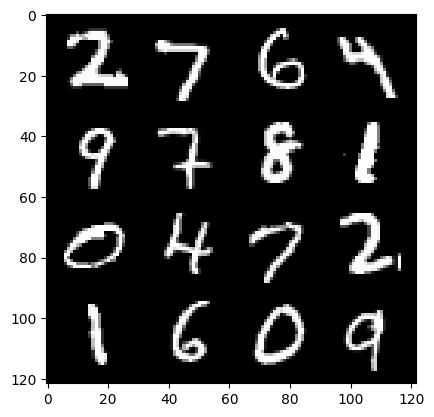

25: step 12000 / Gen loss: 6.63476311206818 / disc_loss: 0.011847927570343017


  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    ### discriminator
    disc_opt.zero_grad()

    cur_bs = len(real) # real: 128 * 1 * 28 * 28
    real = real.view(cur_bs, -1) # 128 * 784
    real = real.to(device)

    disc_loss = cal_disc_loss(loss_func, gen, disc, cur_bs, real, z_dim)

    disc_loss.backward(retain_graph=True)
    disc_opt.step()

    ### generatore
    gen_opt.zero_grad()
    gen_loss = cal_gen_loss(loss_func, gen, disc, cur_bs, z_dim)
    gen_loss.backward(retain_graph= True)
    gen_opt.step()


    ### visualize & stats
    mean_disc_loss += disc_loss.item() / info_step
    mean_gen_loss += gen_loss.item() / info_step


    if cur_step % info_step == 0 and cur_step > 0:
      fake_noise = gen_noise(cur_bs, z_dim)
      fake = gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch}: step {cur_step} / Gen loss: {mean_gen_loss} / disc_loss: {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss =0, 0
    cur_step +=1